Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified: 07/20/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports. The main data sources are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
from utils.get_data import get_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops
from utils.clean_data import PRODUCTS_VAL

pd.set_option('display.float_format', lambda x: '%.4f' % x)

Import cleaned data from Import Genius (IG) and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")
print("Columns IG:\n", ig.columns)
print("Columns BSGI:\n", bsgi.columns)

Columns IG:
 Index(['product', 'hs_code', 'consignee', 'consignee_address', 'shipper',
       'shipper_address', 'date', 'quantity', 'weight_kg', 'invoice_price_uah',
       'total_invoice_value_usd', 'invoice_price_in_kilograms_usd',
       'item_unit', 'item_number', 'customs_value', 'customs_office_code',
       'country_of_origin', 'country', 'place_of_delivery', 'delivery_terms',
       'declaration_no', 'currency_ratio', 'sender_code', 'bank_name',
       'company_searched', 'search_batch', 'year', 'month', 'weight_ton',
       'n_products', 'wheat', 'sunflower', 'mixed', 'peas', 'vegetable',
       'soya', 'barley', 'canola', 'sugar beet', 'corn', 'rapeseed',
       'country_gt'],
      dtype='object')
Columns BSGI:
 Index(['status', '', 'vessel_name', 'imo', 'departure_port', 'country_en',
       'product', 'weight_ton', 'date', 'inspection_cleared', 'income_group',
       'flag', 'world_bank_region', 'un_region', 'development_category', 'wfp',
       'stranded', 'company_searc

We group our data to plot a time series for Kernel, one of the top 10 Ukrainian
agricultural landholders with data from IG. The data goes from February 2021
until March 2023 because it was the most we could export for now with our
subscription. The horizontal axis has the export date in mm-yyyy and the
vertical axis has the total exports volume in metric tons (1,000 kilograms).

We see that there is a shift in the trend of exports in February 2022, when
Russia invaded Ukraine. This makes sense because all Black Sea ports that these
agricultural companies used where closed until the BSGI was signed in July 27,
2022. We can see there was an increase in exports but not as much as in the past.
This could be due to the lack of ports to export (only 3 ports can export at
the Black Sea and a lot of companies have to use the same ports).

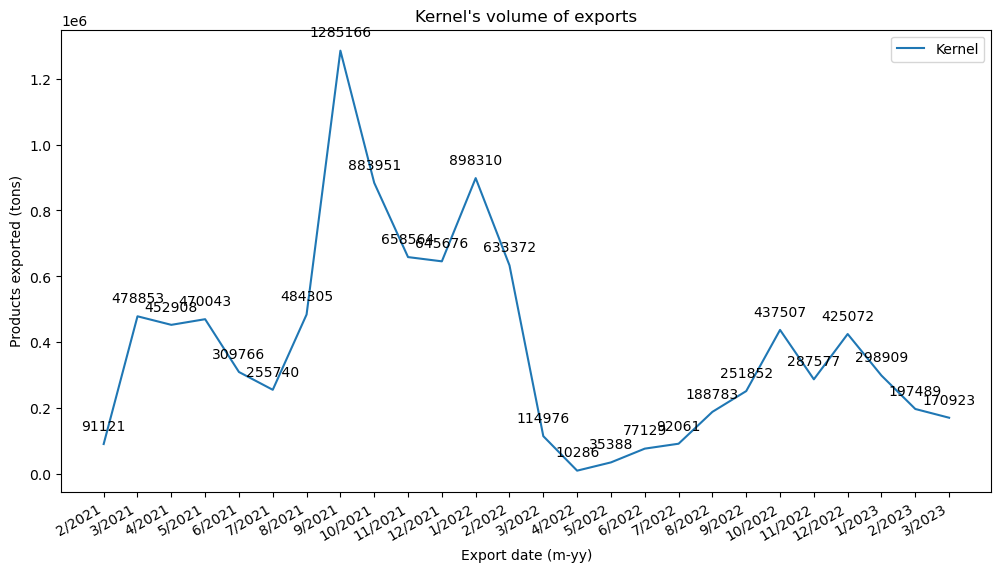

In [3]:
ig_g = cargo_grouping(ig, ["year", "month"], ["weight_ton"], ["year", "month"], True)
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
plot_line(ig_g["date"], [ig_g["weight_ton"]], ["Kernel"], "Kernel's volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

Now we compare Kernel's exports with the overall exports in the ports from the
BSGI by plotting another time series. The horizontal axis has the export date in
mm-yyyy and the vertical axis has the total exports volume in metric tons
(1,000 kilograms).

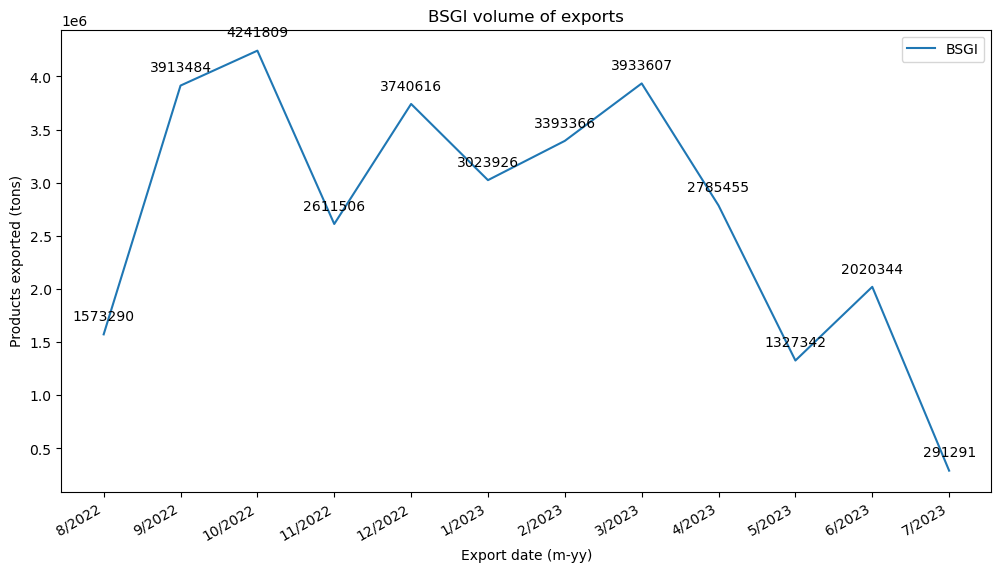

In [4]:
bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True)
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
plot_line(bsgi_g["date"], [bsgi_g["weight_ton"]], ["BSGI"], "BSGI volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

We plot both time series together in the same period (from August 2022 when the
BSGI started) to compare the trends from Kernel and the BSGI more closely. We
see that Kernel's exports have a similar trend than the BSGI total exports except
for the last months of February and March where Kernel's exports decrease and
BSGI's exports increase.

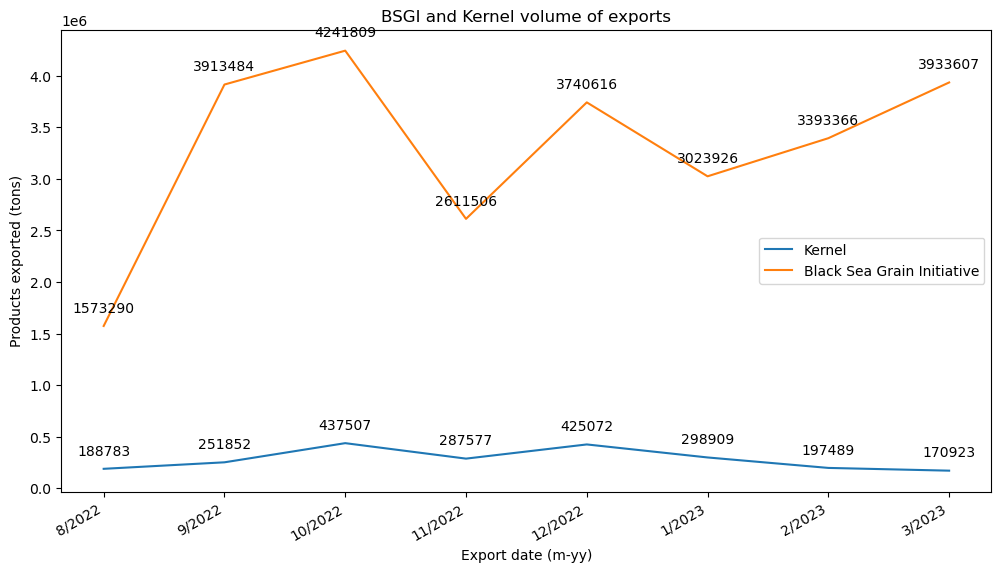

In [5]:
final = ig_g.merge(bsgi_g, on="date", suffixes=("_kernel", "_bsgi"))
plot_line(final["date"], [final["weight_ton_kernel"], final["weight_ton_bsgi"]], ["Kernel", "Black Sea Grain Initiative"], "BSGI and Kernel volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

Here we plot the same time series as before but for each of the crop categories
of the BSGI to compare the volumes of Kernel compared to the BSGI total volumes
in specific crops an get a sense of the size of Kernel's exports.

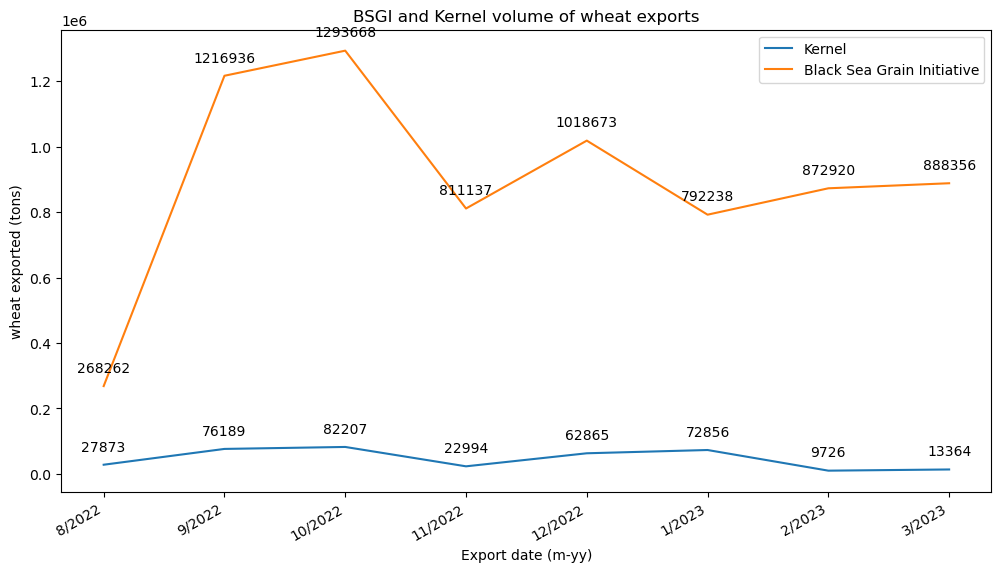

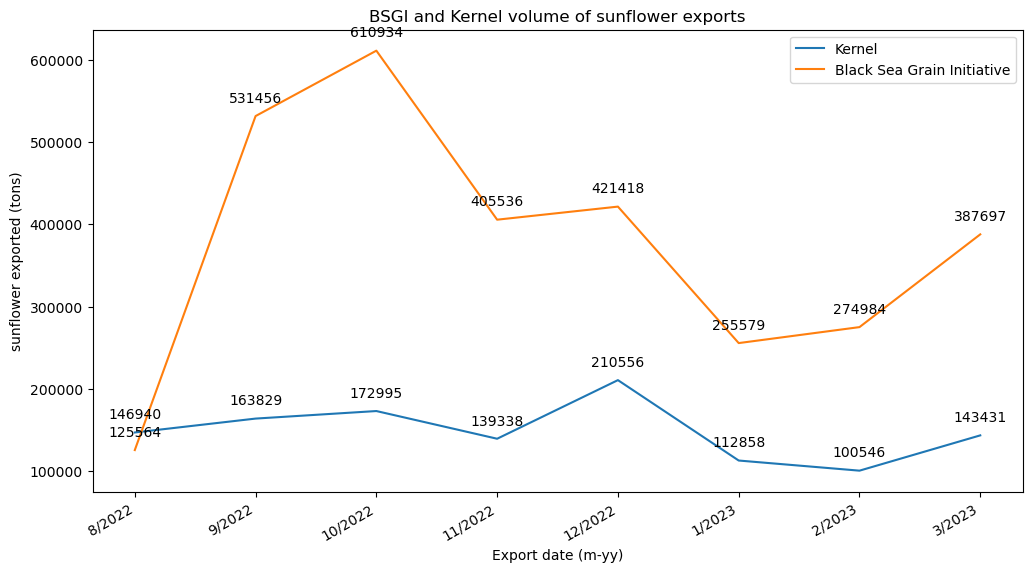

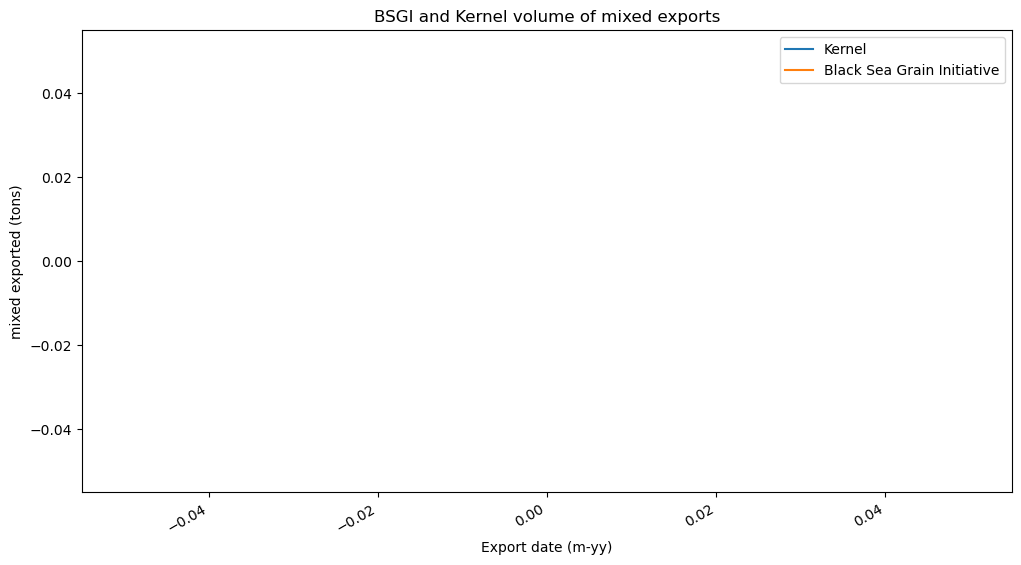

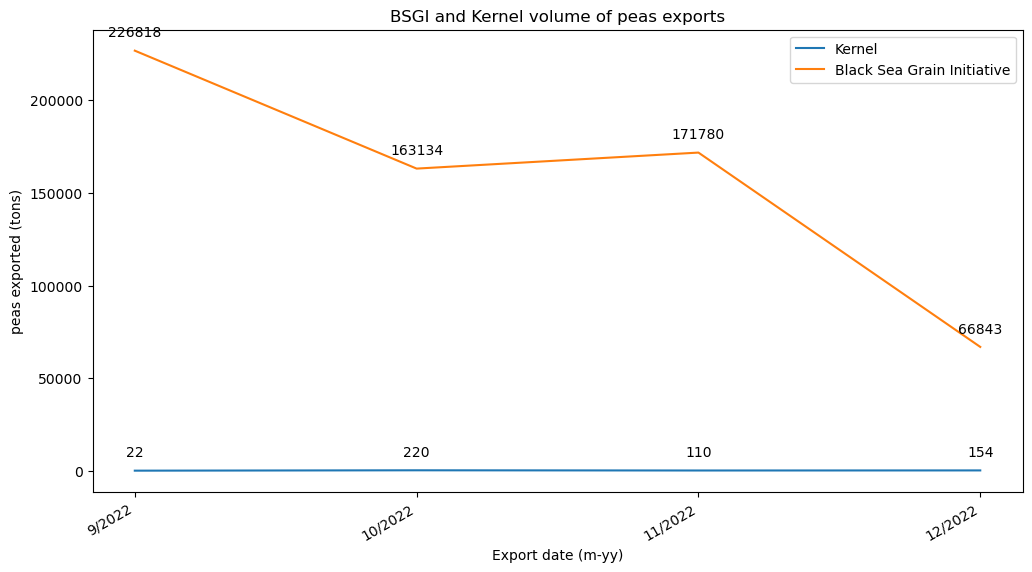

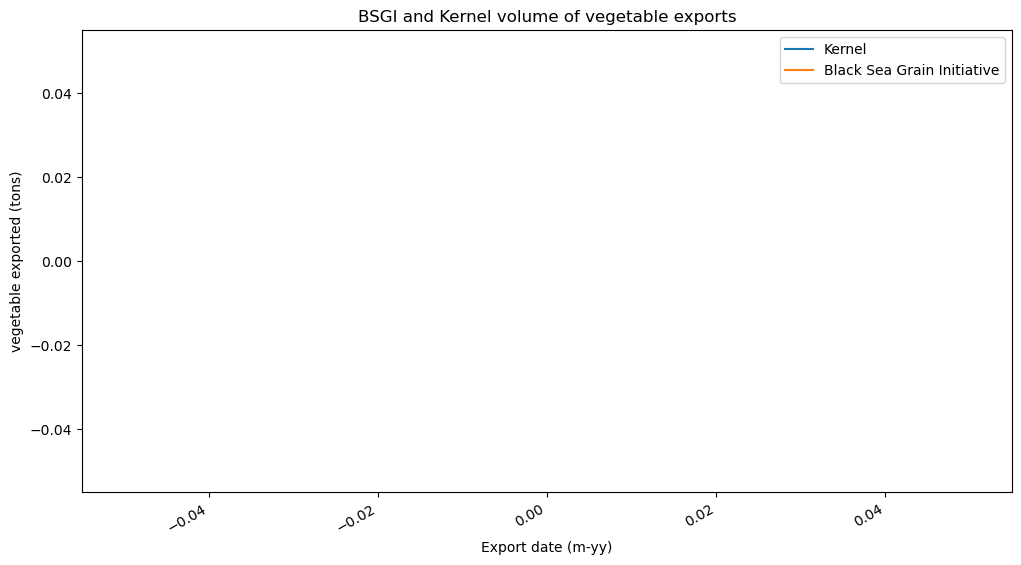

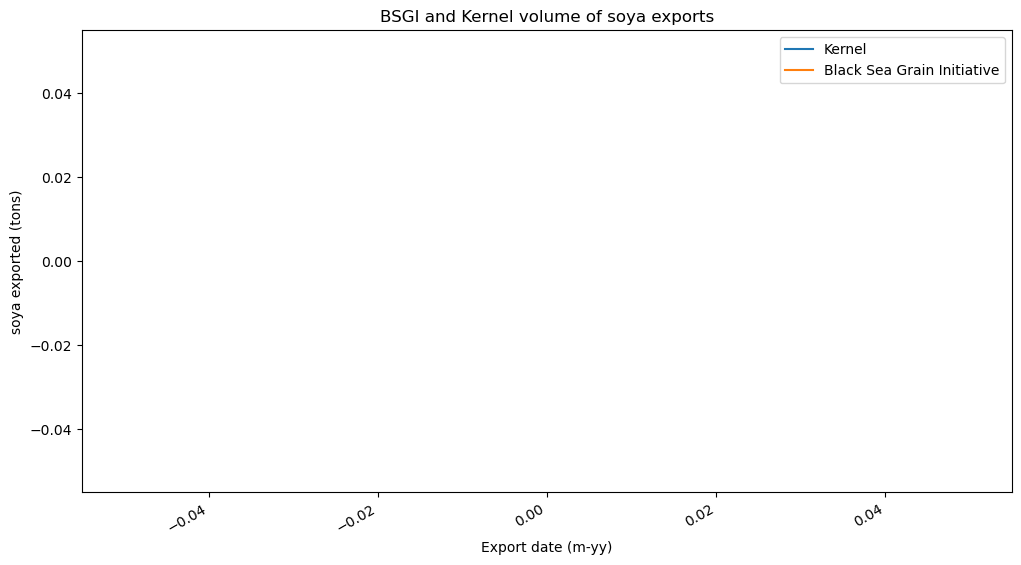

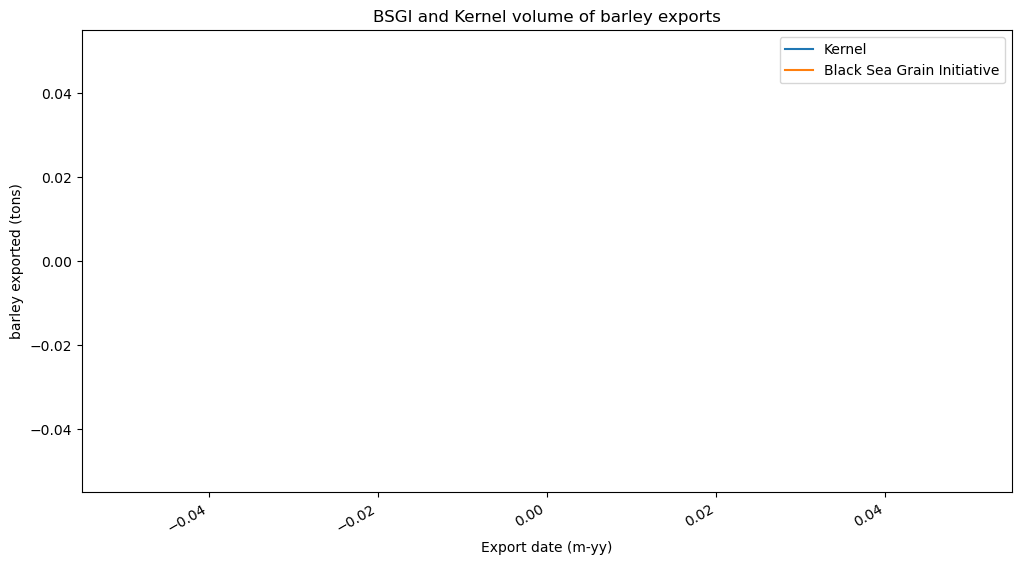

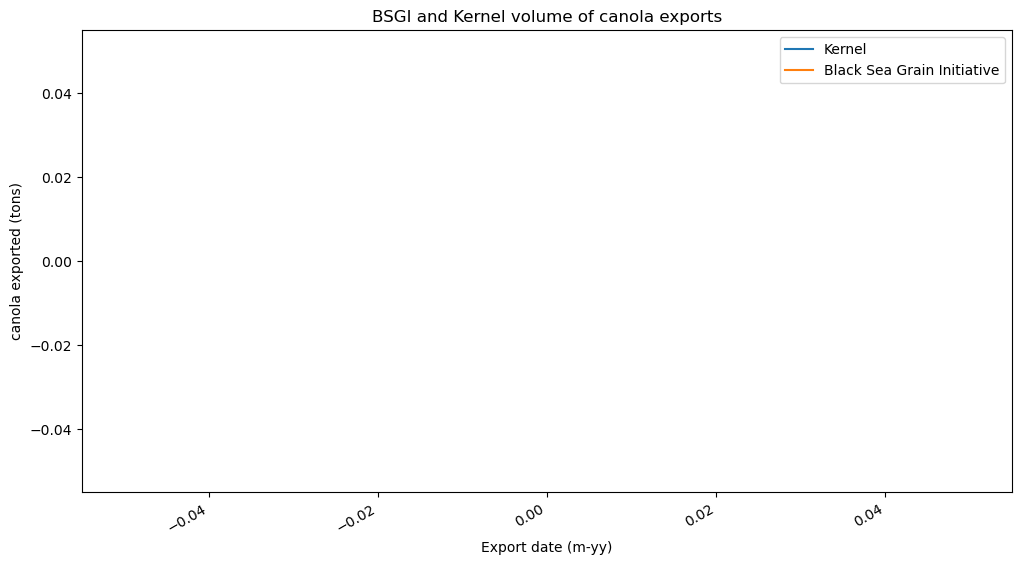

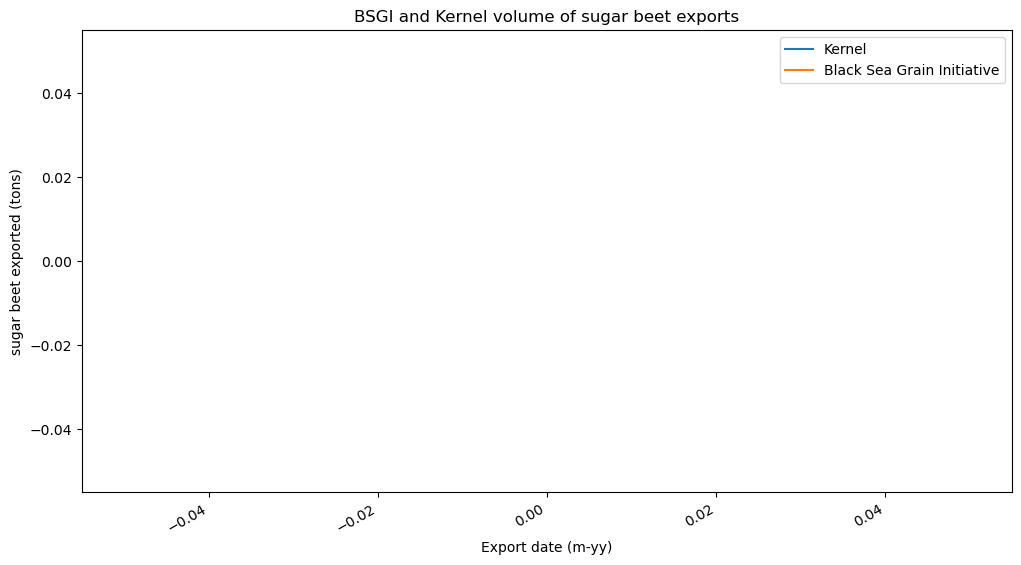

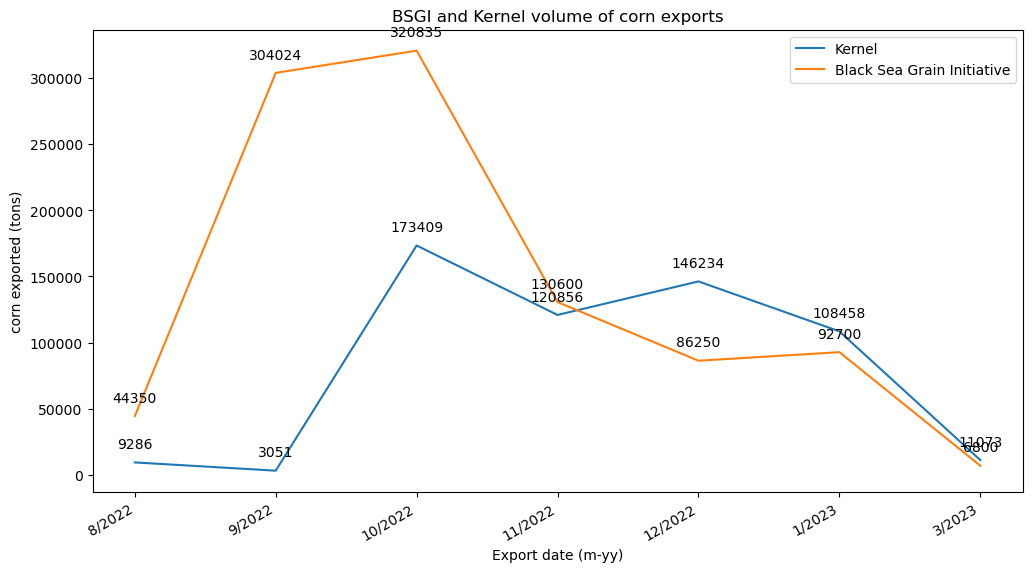

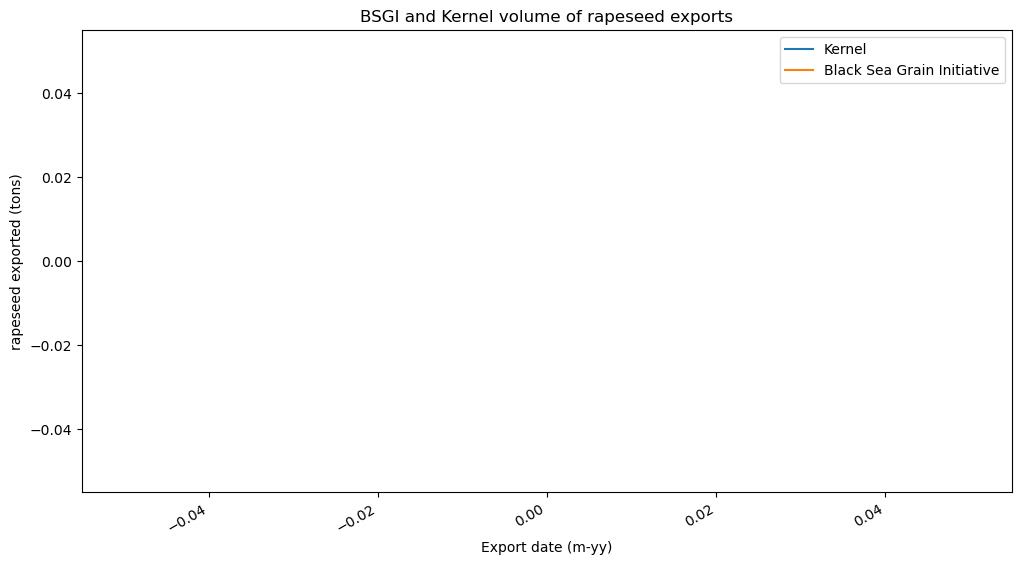

In [6]:
product_std = set(PRODUCTS_VAL)

for crop in product_std:
    plot_crops(crop, ig, bsgi, False)

We start doing some record matching to see if we can merge the BSGI and the IG
data based on export date, country of destination and the exported product.

In [7]:
unique_matches = rl_ig_bsgi(ig, bsgi, "sunflower", ["date"], ["country"], ["date"])
unique_matches[["df_1", "df_2", "date_x", "date_y", "product_std", "country_en", "weight_ton_x", "weight_ton_y"]]

Number of matches:  15


,df_1,df_2,date_x,date_y,product_std,country_en,weight_ton_x,weight_ton_y
0,2008,1122,2022-08-17,2022-08-17,sunflower,the netherlands,59.6160,18500
1,2065,1070,2022-09-02,2022-09-02,sunflower,india,19000.0000,21000
2,2078,1046,2022-09-06,2022-09-06,sunflower,italy,20.0192,5800
3,2116,989,2022-09-15,2022-09-15,sunflower,the netherlands,20.1204,3600
4,2119,985,2022-09-15,2022-09-15,sunflower,italy,20.0192,5750
5,2133,953,2022-09-19,2022-09-19,sunflower,italy,19.4304,4400
6,2150,919,2022-09-23,2022-09-23,sunflower,romania,5723.3380,11950
7,2172,876,2022-09-28,2022-09-28,sunflower,italy,20.0192,5350
8,2290,710,2022-10-25,2022-10-25,sunflower,romania,59.6160,4000
9,2292,707,2022-10-25,2022-10-25,sunflower,spain,6300.0000,6300
